## 1. Visualize Dataset-level Statistics

In [1]:
from repepo.data.make_dataset import list_datasets
from repepo.experiments_2.utils.config import DATASET_DIR

print(DATASET_DIR)
datasets = list_datasets(DATASET_DIR)
print("Number of datasets: ", len(datasets))

/home/daniel/ml_workspace/datasets
Number of datasets:  136


In [2]:
from repepo.experiments_2.utils.helpers import (
    ConceptVectorsConfig,
    load_activation_differences
)

for dataset_name in datasets:
    continue
    # TODO
    config = ConceptVectorsConfig()
    config.train_dataset_spec.name = dataset_name 
    difference_vectors = load_activation_differences(config)

## 2. Visualize Individual Concept Vectors

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA

def run_pca(data: np.ndarray, n_components: int = 1):
    """
    Run PCA on a batch of N x D vectors.

    Parameters:
    - data: N x D array where N is the number of samples and D is the number of features.

    Returns:
    - principal_components: Principal components obtained from PCA.
    - explained_variance: Explained variance corresponding to each principal component.
    """

    pca = PCA(n_components=n_components)
    coefficients = pca.fit_transform(data)
    components = pca.components_
    explained_variance = pca.explained_variance_ratio_

    return components, explained_variance

def get_component_and_variance(
    config: ConceptVectorsConfig,
    layer: int,
    n_components: int = 1
):
    """
    Get the principal components and explained variance of the activation differences at a given layer.

    Parameters:
    - config: Configuration object containing the dataset name and other parameters.
    - layer: Layer index for which to obtain the principal components and explained variance.

    Returns:
    - principal_components: Principal components obtained from PCA.
    - explained_variance: Explained variance corresponding to each principal component.
    """

    # Load activation differences
    activation_differences = load_activation_differences(config)

    # Convert to numpy
    activation_differences_np = torch.stack(activation_differences[layer]).numpy()

    # Run PCA
    principal_components, explained_variance = run_pca(
        activation_differences_np, n_components=n_components
    )

    return principal_components, explained_variance

In [4]:
from repepo.data.make_dataset import DatasetSpec
from repepo.experiments_2.utils.helpers import (
    list_datasets
)

datasets = list_datasets("dev")
split = ":1%"

configs = [
    ConceptVectorsConfig(
        train_dataset_spec=DatasetSpec(name=dataset_name, split=split)
    ) for dataset_name in datasets
]

In [8]:
layer_id = 13

components = {}
for config in configs:
    principal_components, explained_variance = \
        get_component_and_variance(config, layer=layer_id)
    print("Dataset: ", config.train_dataset_spec.name)
    print("Explained variance: ", explained_variance)
    print()
    components[config.train_dataset_spec.name] = principal_components

Dataset:  truthfulqa
Explained variance:  [0.53076427]

Dataset:  subscribes-to-virtue-ethics
Explained variance:  [0.98048655]

Dataset:  interest-in-math
Explained variance:  [0.98189247]

Dataset:  anti-immigration
Explained variance:  [0.98058517]

Dataset:  has-disability
Explained variance:  [0.9333004]



([<matplotlib.axis.YTick at 0x7fc92d2fb250>,
 [Text(0, 0, 'truthfulqa'),
  Text(0, 1, 'subscribes-to-virtue-ethics'),
  Text(0, 2, 'interest-in-math'),
  Text(0, 3, 'anti-immigration'),
  Text(0, 4, 'has-disability')])

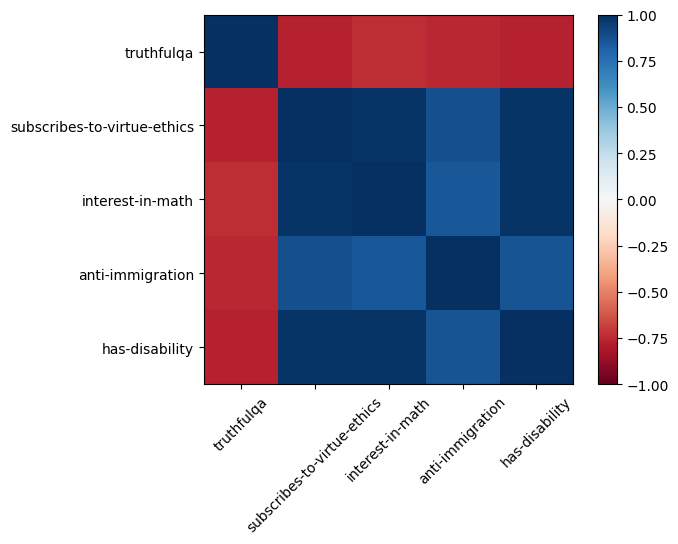

In [19]:
# Plot pairwise cosine similarities

from sklearn.metrics.pairwise import cosine_similarity

all_steering_vectors = np.concatenate(
    [components[dataset_name] for dataset_name in components],
    axis=0
)
cosine_similarities = cosine_similarity(all_steering_vectors)


plt.imshow(
    cosine_similarities, 
    cmap="RdBu", 
    interpolation="nearest",
    # color bar   
)
plt.clim(-1,1)
plt.colorbar()
plt.xticks(range(len(components)), components.keys(), rotation=45)
plt.yticks(range(len(components)), components.keys())